# Sentiment analysis

Sentiment analysis is a NLP technique to determine the sentiment of a sentence. In this implementation, we will focuse on determining the sentiment of the subject of the subject or object or the sentence.

Here I propose some possible sentences for our dataset, indicating where the meaning is encoded.

- Morose man cries. (morose)
- Irascible woman shouts. (irascible)
- Frightened woman shouts. (frightened)
- Joyful kid laughs. (joyful, laughs)
- Furious man snaps. (furious, snaps)
- Kid startles man. (startles)
- Woman grieves man. (grieves)
...


| Nouns | Verbs | Adjectives |
| --- | --- | --- |
| Man | cries | morose |
| Woman | laughs | irascible |
| Kid | shouts | frightened |
|  | snaps | cheerful |
|  | entertains | gloomy |
|  | grieves | furipus |
|  | startles | terrified |
|  | irritates |joyful|

The proposed vocabulary has 19 words and two different kind of sentences:
- Adj + Subject + Intransitive verb
- Subject + Transitive verb + Object

## 1. Create dataset

The first step is to create a dataset using the presented vocabulary. We have to store the words in DisCoPy's Word objects, encoding their meaning (name) and their grammar (codomain). Then, we introduce the grammar of the allowed sentences and create all the possible grammatical sentences. The next step is to assign a sentiment to each sentence. However, there are sentences that although they are grammatically correct, their meaning makes no sense, so we would have to remove them. 

### 1.1. Define the vocabulary

The first step to create a dataset is to define the words, their meaning and the word type. We have four three types of words: nouns, adjectives, verbs. We also distinguish two different types of verbs: transitive and intransitive. 

In [1]:
import numpy as np
import pickle

In [2]:
from discopy import Ty, Word # Import the classes for the type of word and for the word

s, n = Ty('s'), Ty('n') # Define the types s and n
nphr, adj, tv, iv, vphr = Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP')

# Define the words (notice that we include both meaning and grammar)

# nouns
man, woman, kid = Word('man', n), Word('woman', n), Word('kid', n)
# adjectives
morose, irascible = Word('morose', n @ n.l), Word('irascible', n @ n.l)
frightened, cheerful = Word('frightened', n @ n.l), Word('cheerful', n @ n.l)
gloomy, furious = Word('gloomy', n @ n.l), Word('furious', n @ n.l)
terrified, joyful = Word('terrified', n @ n.l), Word('joyful', n @ n.l)
downcast, miserable = Word('downcast', n @ n.l), Word('miserable', n @ n.l)
old, young = Word('old', n @ n.l), Word('young', n @ n.l)
# Intransitive verbs
cries, shouts = Word('cries', n.r @ s), Word('shouts', n.r @ s)
laughs, snaps = Word('laughs', n.r @ s), Word('snaps', n.r @ s)
# Transitive verbs
grieves, startles = Word('grieves', n.r @ s @ n.l), Word('startles', n.r @ s @ n.l)
entertains, irritates = Word('entertains', n.r @ s @ n.l), Word('irritates', n.r @ s @ n.l)

nouns = [man, woman, kid]
adjectives = [morose, irascible, frightened, cheerful, gloomy, furious, terrified, joyful, downcast, miserable, old, young]
int_verbs = [cries, shouts, laughs, snaps]
t_verbs = [grieves, startles, entertains, irritates]

vocab = nouns + int_verbs + t_verbs + adjectives

### 1.2. Define the grammar

In this dataset we are going to consider the following structures to construct the sentences:

- adj + noun + int. verb
- noun + t. verb + noun

- Intransitive sentence

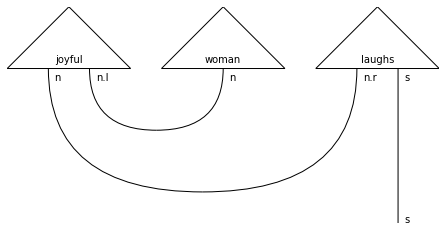

In [3]:
from discopy import Cup, Id, pregroup

grammar =  Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s)
sentence = joyful @ woman @ laughs >> grammar
pregroup.draw(sentence)

- Transitive sentence

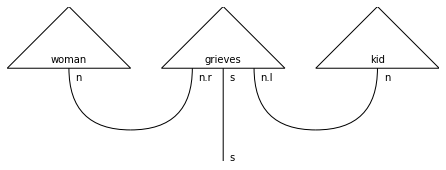

In [4]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
sentence = woman @ grieves @ kid >> grammar
pregroup.draw(sentence)

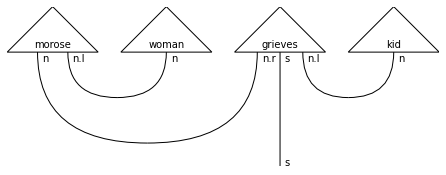

In [5]:
grammar =  Id(n) @ Cup(n.l, n) @ Id(n.r @ s) @ Cup(n.l, n) >> Cup(n, n.r) @ Id(s) >> Id(s)
sentence = morose @ woman @ grieves @ kid >> grammar
pregroup.draw(sentence)

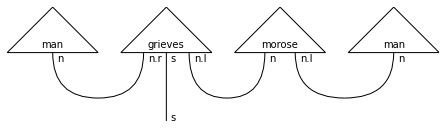

In [6]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n) >> Id(s)
sentence =  man @ grieves @ morose @ man >> grammar
pregroup.draw(sentence)

Now we have seen how the grammatical structure of each type of sentence is, so we are ready to obtain all the grammatical sentences that we can construct with them with the vocabulary that we are using. 

In [7]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures in a dictionary 

grammar_dict = {
    'ADJ_N_IV' : Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
    'ADJ_N_TV_N': Id(n) @ Cup(n.l, n) @ Id(n.r @ s) @ Cup(n.l, n) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_ADJ_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n) >> Id(s)}
                                                                          

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)

data_psr = {}

# Intransitive sentences
parsing_int = {"{} {} {}.".format(adj, noun, int_verb): adj @ noun @ int_verb >> grammar_dict['ADJ_N_IV']
            for adj in adjectives for noun in nouns for int_verb in int_verbs}
sentences_int = list(parsing_int.keys())
for sentence in sentences_int:
    diagram = parsing_int[sentence]
    data_psr[sentence] = parsing_int[sentence]

# Transitive sentences (without adjective)
parsing_tra = {"{} {} {}.".format(subj, t_verb, obj):  subj @ t_verb @ obj >> grammar_dict['N_TV_N']
            for subj in nouns for t_verb in t_verbs for obj in nouns}


# Transitive sentences (with adjective)
parsing_tra_ladj = {"{} {} {} {}.".format(adj, subj, t_verb, obj):  adj @ subj @ t_verb @ obj >> grammar_dict['ADJ_N_TV_N']
            for adj in adjectives for subj in nouns for t_verb in t_verbs for obj in nouns}
parsing_tra_radj = {"{} {} {} {}.".format(subj, t_verb, adj, obj):  subj @ t_verb @ adj @ obj >> grammar_dict['N_TV_ADJ_N']
            for subj in nouns for t_verb in t_verbs for adj in adjectives for obj in nouns}

parsing_tra.update(parsing_tra_ladj) #merges transitive adjectives into original dict
parsing_tra.update(parsing_tra_radj)

sentences_tra = list(parsing_tra.keys())
for sentence in sentences_tra:
    diagram = parsing_tra[sentence]
    data_psr[sentence] = parsing_tra[sentence]

Now, we have the dataset with the sentences and their corresponding meaning and grammar. The next step is to design the corresponding quantum circuits to determine the sentiment for each sentence. We are aiming to distinguish between four different emotions: happy (0), sad (1), angry (2), scared (3). However, some sentences of the dataset cannot be clearly classified according to this criteria (for example, 'Old man cries'). Therefore, the next step is to manually modify the dataset so all the sentences can be classified according to this criteria. In order to do that we will create a .txt file and assign the corresponding class to the viable sentences.

### 1.3. Process the data

In [8]:
with open('train_sad_vs_scared.txt') as f:
    data = f.readlines()

In [9]:
labels_dict = {}
data_psr_dict = {}
sent_type = {}

adjective_words = [a.name for a in adjectives]
for sentence in data:
    sentstr = sentence[:-7]
    if sentence[-6:-3] == 'int':
        diagram = parsing_int[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'int'
    elif sentence[-6:-3] == 'tra':
        diagram = parsing_tra[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]

        if len(sentstr.split()) == 4:
            if sentstr.split()[0] in adjective_words:
                sent_type[sentstr] = 'tra_' + 'l'
            else:
                sent_type[sentstr] = 'tra_' + 'r'
        else:
            sent_type[sentstr] = 'tra'  

In [10]:
len(data)

137

In [11]:
c0 = 0
c1 = 0
c2 = 0
c3 = 0
for value in labels_dict.values():
    if value == '0':
        c0 +=1
    elif value == '1':
        c1 += 1
    elif value == '2':
        c2 += 1
    elif value == '3':
        c3 += 1
print('Number of elements for each sentiment')
print('Happy: ', c0)
print('Sad: ', c1)
print('Angry: ', c2)
print('Scared: ', c3)
print('Total', len(data_psr_dict))

Number of elements for each sentiment
Happy:  71
Sad:  66
Angry:  0
Scared:  0
Total 137


Now we have our dataset! The only problem left is the fact that the cups used in the diagrams are too resource consumming. Luckily, it is possible to remove them by transforming the states into effects (we are just doing this with the nouns as in https://github.com/CQCL/qnlp_lorenz_etal_2021_resources). Let us see some examples

In [12]:
from discopy import Cap, Box

Let us apply this to our entire dataset.

In [13]:
data_new_psr_dict = {}
for sentstr in data_psr_dict.keys():
    num_words = len(sentstr.split(' '))
    words = data_psr_dict[sentstr].boxes[:num_words]
    if sent_type[sentstr] == 'int':
        noun = Box(words[1].name, n.l, Ty())
        words_new = (Cap(n, n.l)) >> (words[0] @ Id(n) @ noun @ words[2])
        sentence = words_new >> grammar_dict['ADJ_N_IV']
        data_new_psr_dict[sentstr] = sentence.normal_form()
    elif 'tra' in sent_type[sentstr]:
        if sent_type[sentstr] == 'tra':
            noun1 = Box(words[0].name, n.r, Ty())
            noun2 = Box(words[2].name, n.l, Ty())
            words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['N_TV_N']
            data_new_psr_dict[sentstr] = sentence.normal_form()
        elif sent_type[sentstr] == 'tra_l': #adjective at beginning
            noun1 = Box(words[1].name, n.l, Ty())
            noun2 = Box(words[3].name, n.l, Ty())
            words_new = (Cap(n, n.l) @ Cap(n, n.l)) >> (words[0] @ Id(n) @ noun1 @ words[2] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['ADJ_N_TV_N']
            data_new_psr_dict[sentstr] = sentence.normal_form()
        elif sent_type[sentstr] == 'tra_r': #adjective on second noun
            noun1 = Box(words[0].name, n.r, Ty())
            noun2 = Box(words[3].name, n.l, Ty())
            words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ words[2] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['N_TV_ADJ_N']
            data_new_psr_dict[sentstr] = sentence.normal_form() 

The final step before the implementation of the quantum circuit is to redefine the vocabulary according to the new domain and codamain for the nouns as effects.

In [14]:
vocab_psr = []
for word in vocab:
    if word.cod == Ty('n'):
        vocab_psr.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr.append(word)

## 2. Create quantum circuit

Once the dataset and its corresponding diagrams are created, the next step is to construct the variational quantum circuits associated with them. In order to do that, we will use different ansätze depending on the type of the word that we want to represent. In this case we only have two types of words, nouns and verbs. Both types will have associated 2 qubits (as we have four sentiments, we need 4 quantum states to encode the result of the classification). Moreover, we will also distinguish between states and effects when constructing the ansätze.

In [15]:
from discopy.quantum import Ket, IQPansatz, Bra, qubit
from discopy.quantum.circuit import Functor, Id
from discopy.quantum.circuit import Circuit
from functools import reduce, partial
from discopy.quantum.gates import Rx, Rz

import numpy as np

q_s = 1 # number of qubits for type s (sentence)
q_n = 1 # number of qubits for type n (noun)
depth = 1 # depth of the IQPansatz
p_n = 3 # number of parameters for the single qubit iqp ansatz

# Define the dimensions of the objects of the circuit functor
ob = {s: q_s, n: q_n}                          
ob_cqmap = {s: qubit ** q_s, n: qubit ** q_n}   

# Define the ansätze for states and effects

def single_qubit_iqp_ansatz(params):
    if len(params) == 1:
        return Rx(params[0])  
    if len(params) == 2:
        return Rx(params[0]) >> Rz(params[1])
    if len(params) == 3:
        return IQPansatz(1, params)     
    
def ansatz_state(state, params):
    arity = sum(ob[Ty(factor.name)] for factor in state.cod) 
    if arity == 1:
        return Ket(0) >> single_qubit_iqp_ansatz(params)
    return Ket(*tuple([0 for i in range(arity)])) >> IQPansatz(arity, params)
    
def ansatz_effect(effect, params): 
    arity = sum(ob[Ty(factor.name)] for factor in effect.dom)
    if arity == 1:
        return single_qubit_iqp_ansatz(params) >> Bra(0)
    return IQPansatz(arity, params) >> Bra(*tuple([0 for i in range(arity)]))
       
def ansatz(box,params):
    dom_type = box.dom
    cod_type = box.cod
    if len(dom_type) == 0 and len(cod_type) != 0:
        return ansatz_state(box, params)
    if len(dom_type) != 0 and len(cod_type) == 0:
        return ansatz_effect(box, params)

# Construct the circuit functor
def F(params): 
    ar = dict()
    for i in range(len(vocab_psr)):
        pgbox = vocab_psr[i]
        qbox = ansatz(vocab_psr[i], params[i])
        ar.update({pgbox: qbox})
        if pgbox.cod == Ty():
            ar.update({Box(pgbox.name, n.l, Ty()): qbox})
    return Functor(ob_cqmap, ar)

In [16]:
#*****************************************************
# Functions to deal with the parametrisation
#*****************************************************

def paramshapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0:  # states and effects
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            parshapes.append((depth, arity-1))
    return parshapes

def paramshapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0:  # states and effects
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            if arity == 1:
                parshapes.append((p_n,))       
            if arity != 1:
                parshapes.append((depth, arity-1))
    return parshapes

def randparams(par_shapes):
    params = np.array([]) 
    for i in range(len(par_shapes)):
        params = np.concatenate((params, np.ravel(np.random.rand(*par_shapes[i])))) # np.ravel flattens an array
    return params 

def reshape_params(unshaped_pars, par_shapes):
    pars_reshaped = [[] for ii in range(len(par_shapes))]
    shift = 0
    for ss, s in enumerate(par_shapes):
        idx0 = 0 + shift
        if len(s) == 1:
            idx1 = s[0] + shift
        elif len(s) == 2:
            idx1 = s[0] * s[1] + shift
        pars_reshaped[ss] = np.reshape(unshaped_pars[idx0:idx1], s)
        if len(s) == 1:
            shift += s[0]
        elif len(s) == 2:
            shift += s[0] * s[1]
    return pars_reshaped

In [17]:
#****************************************
# Parameters of the current model
#****************************************

par_shapes = paramshapes(vocab_psr)
rand_unshaped_pars = randparams(par_shapes)
rand_shaped_pars = reshape_params(rand_unshaped_pars, par_shapes)

print('Number of parameters:    ', len(rand_unshaped_pars))

Number of parameters:     33


## 3. Create training and test dataset

The next step is to divide our dataset into training and test data, so we can perform the classification using a supervised quantum machine learning technique. We need the data, which are the quantum circuits associated to each sentences, and the labels, that encode the sentiment. In this case the labels are the four possible quantum states that can be obtained from measuring a 2-qubit quantum circuit:

- Happy: $ \ 0 \ \rightarrow \ |00\rangle = [1,0,0,0] \ \rightarrow \ p_{00}=1$,
- Sad: $ \ 1 \ \rightarrow \ |01\rangle = [0,1,0,0] \ \rightarrow \ p_{01}=1$,
- Angry: $ \ 2 \ \rightarrow \ |10\rangle = [0,0,1,0] \ \rightarrow \ p_{10}=1$,
- Scared: $ \ 3 \ \rightarrow \ |11\rangle = [0,0,0,1] \ \rightarrow \ p_{11}=1$.

In [18]:
from sklearn.model_selection import train_test_split

psr_diagrams = []
psr_diagrams_dict = {}
psr_labels = []
sentences = []

for sentstr in data_new_psr_dict.keys():
    sentences.append(sentstr)
    diagram = data_new_psr_dict[sentstr]
    psr_diagrams.append(diagram)
    psr_diagrams_dict[sentstr] = diagram
    if labels_dict[sentstr] == '0':
        label = np.array([1,0])
    elif labels_dict[sentstr] == '1':
        label = np.array([0,1])
    psr_labels.append(label)

In [19]:
train_data_psr = psr_diagrams
train_labels = psr_labels
train_sent = sentences

I'm not sure how to make the statevector simulator and the qasm simulator work with the measurements made in DisCoPy.

### Qiskit SPSA implementation

In [20]:
from qiskit import BasicAer, execute, ClassicalRegister
from pytket.extensions.qiskit import tk_to_qiskit
from qiskit.quantum_info import Statevector
from qiskit import IBMQ, Aer, execute, QuantumCircuit
provider = IBMQ.load_account()
from qiskit.providers.aer.noise import NoiseModel

# Build noise model from backend properties
backend = provider.get_backend('ibmq_16_melbourne')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

backend = Aer.get_backend('qasm_simulator')

max_shots = 8192

n_iterations = 2000

pickle.dump([noise_model, coupling_map, basis_gates], open(f"noise_model.pkl", "wb"))

C:\Users\Paula\Anaconda3\envs\qnlp\lib\site-packages\qiskit\aqua\operators\operator_globals.py:48: DeprecationWarning: `from_label` is deprecated and will be removed no earlier than 3 months after the release date. Use Pauli(label) instead.
  X = make_immutable(PrimitiveOp(Pauli.from_label('X')))
C:\Users\Paula\Anaconda3\envs\qnlp\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [21]:
with open(f'./noise_model_melbourne.pkl', "rb") as fp:  
    data = pickle.load(fp)
noise_model, coupling_map, basis_gates = data[0], data[1], data[2]

In [22]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2,2)
qc.x(0)
qc.cx(1,0)
qc.h(1)
qc.measure_all()
results = execute(qc, Aer.get_backend('qasm_simulator'), shots=max_shots, noise_model=noise_model, 
                              coupling_map=coupling_map,basis_gates=basis_gates).result().get_counts()
print(results)

{'00 00': 243, '01 00': 3968, '10 00': 213, '11 00': 3768}


In [23]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2,2)
qc.x(0)
qc.cx(1,0)
qc.h(1)
qc.measure_all()
results = execute(qc, Aer.get_backend('qasm_simulator'), shots=max_shots).result().get_counts()
print(results)

{'01 00': 4127, '11 00': 4065}


In [24]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2,2)
qc.x(0)
qc.cx(1,0)
qc.h(1)
qc.measure_all()
results = execute(qc, BasicAer.get_backend('qasm_simulator'), shots=max_shots, noise_model=noise_model).result().get_counts()
print(results)

{'01 00': 4173, '11 00': 4019}


C:\Users\Paula\Anaconda3\envs\qnlp\lib\site-packages\qiskit\execute_function.py:343: UserWarning: Option noise_model is not used by this backend
  job = backend.run(experiments, **run_kwargs)


In [25]:
def get_qiskit_results(circ, s_type, retries=10, qasm=False, noise_model=None, basis_gates=None, coupling_map=None):
    """Function to get the Qiskit's results from a DisCoPy circuit.
    
    Args:
        circ: DisCoPy circuit.
        s_type: sentence type for the sentence associated to the circuit.
        retries: number of retries before assigning a random result
            if the postselection leads to zero values (Default is 10).
        qasm: if True qasm_simulator is used, if not statevector_simulator
            (Default is False).
            
    Returns:
        array: results from the postselection measurement.
    """
    
    # Select qubits for postselection according to the sentence type    
    
    if s_type == 'int':
        n_qubits = 4
        post = 2
    elif s_type == 'tra':
        n_qubits = 3
        post = 1
    elif s_type == 'tra_l':
        n_qubits = 5
        post = 2
    else:
        assert s_type == 'tra_r'
        n_qubits = 5
        post = 1
    
    # From DisCoPy to Qiskit circuit    
    qc = tk_to_qiskit(circ.to_tk())
    if qasm == True:
        backend = Aer.get_backend('qasm_simulator')
        #qasm_simulator
        out_reg = ClassicalRegister(1)
        qc.add_register(out_reg)
        qc.measure(post, out_reg[0]) 
        if noise_model is not None:
            # Include noise model
            results = execute(qc, backend, shots=max_shots, noise_model=noise_model, 
                              coupling_map=coupling_map,basis_gates=basis_gates).result().get_counts()
        else:
            results = execute(qc, backend, shots=max_shots).result().get_counts()

        zeros = '0' * (n_qubits - 1)

        if '0 ' + zeros not in results and '1 ' + zeros not in results:
            if retries == 0:
                return np.random.rand(2)
            return get_qiskit_results(circ, s_type, transpile, retries=retries-1, qasm = qasm_bool)

        return parse_results(results, eff=zeros)
        
    else:
        # statevector_simulator
        qc.remove_final_measurements()
        state_dict = Statevector(qc).to_dict()
        post0, post1 = '0' * n_qubits, '0' * n_qubits
        post1 = post1[:post] + '1' + post1[post + 1:]
        return [np.abs(state_dict[post0])**2, np.abs(state_dict[post1])**2]
    
def parse_results(results, eff='0'):
    ks = [k for k in results.keys() if k.split()[1] == eff]
    post_selected_results = {k.split()[0]:v for (k,v) in results.items() if k in ks}
    
    if '0' not in post_selected_results:
        post_selected_results['0'] = 0
    if '1' not in post_selected_results:
        post_selected_results['1'] = 0
        
    total = post_selected_results['0'] + post_selected_results['1']
    
    assert total > 0, 'total was 0 after postselection - try running with more shots'
    
    
    return [post_selected_results['0']/total,  post_selected_results['1']/total]

In [ ]:
from qiskit.aqua.components.optimizers import SPSA

import time

cost_save = []
params_save = []
i_cost = []

def get_cost(unshaped_params):
    i_cost.append(1)
    if len(i_cost) % 2 == 0:
        print('Iteration', len(i_cost)/2)
    func = F(reshape_params(unshaped_params, par_shapes))
    
    circs = [func(diag) for diag in train_data_psr]
    
    results = np.array([get_qiskit_results(circs[i], sent_type[train_sent[i]]) for i in range(len(train_sent))])

    
    results_tweaked = [np.abs(np.array(res) - 1e-9) for res in results] #from before
    pred_labels_distrs = [res.flatten() / np.sum(res) for res in results_tweaked]
    
    cross_entropies = np.array([np.sum(train_labels[s] * np.log2(pred_labels_distrs[s])) for s in range(len(train_labels))])
    print('Cost', -1 / len(train_data_psr) * np.sum(cross_entropies))
    cost_save.append(-1 / len(train_data_psr) * np.sum(cross_entropies))
    params_save.append(unshaped_params)
    return -1 / len(train_data_psr) * np.sum(cross_entropies)

rand_unshaped_pars = randparams(par_shapes)
num_vars = len(rand_unshaped_pars)


bounds = [[0.0, 1.0] for _ in range(len(rand_unshaped_pars))]

ps = {}

rand_unshaped_pars = randparams(par_shapes)

n_iterations = 2000

t1 = time.time()
opt = SPSA(maxiter=n_iterations)
ps = opt.optimize(num_vars, get_cost, initial_point=rand_unshaped_pars, variable_bounds=bounds)#, gradient_function=grad_func) 
print("Final time", time.time() - t1)
pickle.dump([ps, cost_save, params_save], open(f"sentiment_analysis_1vs1_sad_vs_scared_get_cost_train_niter{n_iterations}_qasm_noise.pkl", "wb"))

Cost 1.243106774792069
Iteration 1.0
Cost 1.4598302993421488
Cost 1.2235584210241655
Iteration 2.0
Cost 1.1997120031316173
Cost 1.3607955864993653
Iteration 3.0
Cost 1.3188492940323235
Cost 1.1733426812907428
Iteration 4.0
Cost 1.2828253507118867
Cost 1.245444889635116
Iteration 5.0
Cost 1.3959402279188882
Cost 1.3448223702865743
Iteration 6.0
Cost 1.3300863175131423
Cost 1.502885965267327
Iteration 7.0
Cost 1.063000127953393
Cost 1.501153121958981
Iteration 8.0
Cost 1.1050147152131717
Cost 1.4534692535027325
Iteration 9.0
Cost 1.368007685303423
Cost 1.4826309298820586
Iteration 10.0
Cost 1.6270131957244973
Cost 1.100470287496891
Iteration 11.0
Cost 1.6446756123464452
Cost 1.3356116695649456
Iteration 12.0
Cost 1.3755051651937444
Cost 1.3222938448083912
Iteration 13.0
Cost 1.289261477685696
Cost 1.1900461173296666
Iteration 14.0
Cost 1.0721851775284859
Cost 1.2531801682260217
Iteration 15.0
Cost 1.2475273453540812
Cost 1.2181352573653421
Iteration 16.0
Cost 1.4437011766177996
Cost 1.47

Cost 1.0260560178987
Cost 0.9752240723421219
Iteration 132.0
Cost 1.1109386519867357
Cost 1.0746605340457065
Iteration 133.0
Cost 0.9168243152584272
Cost 0.8874219289718457
Iteration 134.0
Cost 1.1807578634367597
Cost 0.9698489535705118
Iteration 135.0
Cost 1.1568431289745567
Cost 0.8975026742083567
Iteration 136.0
Cost 1.3600780638973338
Cost 1.4010865396654069
Iteration 137.0
Cost 1.4363519960323743
Cost 1.221113612426052
Iteration 138.0
Cost 2.2134964375759028
Cost 0.8945474815730484
Iteration 139.0
Cost 1.2521951311273225
Cost 1.1167067302301021
Iteration 140.0
Cost 1.172707173584994
Cost 1.0892697082857186
Iteration 141.0
Cost 1.1460198660936745
Cost 1.4055798694239674
Iteration 142.0
Cost 1.021215385980698
Cost 1.2960268006026274
Iteration 143.0
Cost 1.062794358533186
Cost 1.1439484229245025
Iteration 144.0
Cost 1.0260138395411442
Cost 1.2423607235266396
Iteration 145.0
Cost 1.040570673518563
Cost 1.1948609826015728
Iteration 146.0
Cost 1.2906825718823092
Cost 1.0916820606485416


Cost 0.7474499886775436
Cost 0.690723164942349
Iteration 261.0
Cost 0.6633935204565133
Cost 0.7596586937204577
Iteration 262.0
Cost 0.7605566603655265
Cost 0.7609397093286351
Iteration 263.0
Cost 0.7137786462944876
Cost 0.7080426170035212
Iteration 264.0
Cost 0.6646448678718077
Cost 0.6727177807866789
Iteration 265.0
Cost 0.6400302720252039
Cost 0.68742274672635
Iteration 266.0
Cost 0.6587355116906272
Cost 0.6753236487933938
Iteration 267.0
Cost 0.643633378967494
Cost 0.6588212608093301
Iteration 268.0
Cost 0.6447804420869908
Cost 0.7766300308008051
Iteration 269.0
Cost 0.8184276153392268
Cost 0.7270936257721806
Iteration 270.0
Cost 0.7321087735531049
Cost 0.8369890564074508
Iteration 271.0
Cost 0.7103404665053319
Cost 0.7636340302591228
Iteration 272.0
Cost 0.6623548395086039
Cost 0.694726137278961
Iteration 273.0
Cost 0.8203514590405321
Cost 0.6612561833301593
Iteration 274.0
Cost 0.6782930624861261
Cost 0.6755704058889724
Iteration 275.0
Cost 0.7329208712741091
Cost 0.76956601129286

In [ ]:
import pickle
import matplotlib.pyplot as plt
with open(f"sentiment_analysis_1vs1_happy_vs_sad_get_cost_cross_entropy_niter{n_iterations}_qasm_noise.pkl", "rb") as fp:  
    data = pickle.load(fp)
cost_data = data[1][:-1]
cost_save_plus = []
cost_save_minus = []
for i in range(0,len(cost_data)):
    if i % 2:
        cost_save_plus.append(cost_data[i])
    else:
        cost_save_minus.append(cost_data[i])
cost_save_plus = np.asarray(cost_save_plus)
cost_save_minus = np.asarray(cost_save_minus)
cost = 0.5 * (cost_save_plus+cost_save_minus)
plt.plot(cost[25:])

final_params = data[0][0]
func = F(reshape_params(final_params, par_shapes))
final_train_circuits = [func(diag) for diag in train_data_psr]
train_results = [get_qiskit_results(final_train_circuits[i], train_sent[i]) for i in range(len(train_sent))]
train_results_tweaked = [np.abs(np.array(res) - 1e-9) for res in train_results]
pred_train_results = [res.flatten() / np.sum(res) for res in train_results_tweaked]
    
correct = 0
correct_train0 = 0
correct_train1 = 0
train0 = 0
train1 = 0
for i, res in enumerate(pred_train_results):
    pred_result = np.argmax(res.flatten())
    train_result = np.argmax(train_labels[i])
    if train_result == 0:
        train0 +=1
    else:
        train1 +=1
    if train_result == pred_result:
        correct += 1
        if train_result == 0:
            correct_train0 += 1
        else:
            correct_train1 += 1
    #print(f'Result: {train_array, train_result}, Predicted result: {res, pred_result}')
print('Correct predictions (train):',correct/len(train_results_tweaked))
print('Correct predictions (train0):',correct_train0/train0)
print('Correct predictions (train1):',correct_train1/train1)